<a href="https://colab.research.google.com/github/anon-researchers/sliced_bures_flows/blob/master/flows_sliced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install POT
! pip install celluloid
! pip install multipledispatch

In [ ]:
! git clone https://github.com/anon-researchers/sliced_bures_flows
% cd src/

In [ ]:
from utils import load_data
from utils import seed_everything
from utils import rand_Fourier

from utils_loss import loss
from utils_distances import weighted_w2_distance\
    
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim
from celluloid import Camera
from IPython import display

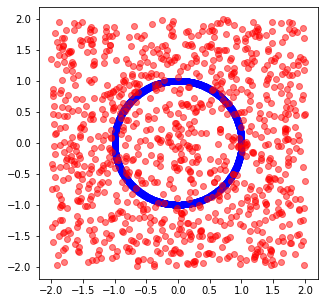

In [ ]:
# Target and source distributions
N = 1000  # Number of samples from p_X(target) and p_Y(target)

# Target:
# in  ['swiss_roll','circle','8gaussians','25gaussians']:
dataset_name = 'circle' 
X = load_data(name=dataset_name, n_samples=N)
# Number of dimensions "d"
_, d = X.shape
X -= X.mean(dim=0)[np.newaxis,:]  # Normalization

# Source:
#Y = torch.from_numpy(np.random.normal(loc=meanX, scale=0.5, size=(N,d))).float()
Y = torch.from_numpy((np.random.rand(N,d)-0.5)*4 ).float()
# Show the both distributions
fig = plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(Y[:, 0], Y[:, 1],  c='r', alpha = 0.5)
plt.show()

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
seed_everything()
iter = 50
lr = 1e-3
temp = np.ones((N,))/N
# weights = torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device)
# optimizer = optim.Adam([weights], lr)
methods = [[(''),('linear','wasserstein'),('circular','wasserstein')],
           [(''),('linear','bures'),('circular','bures')],
           [(''),('linear','mean'),('circular','mean')]]
rows = np.array(methods, dtype=object).shape[0]
cols = np.array(methods, dtype=object).shape[1]

methods_colors = [['','#1f77b4','#ff7f0e'],
                  ['','#2ca02c','#d62728'],
                  ['','#9467bd','#8c564b']]
methods_weights = [[(''),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device)],
                   [(''),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device)],
                   [(''),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device)]]
methods_optimizer = [[(''),optim.Adam([methods_weights[0][1]],lr), optim.Adam([methods_weights[0][2]],lr)],
                     [(''),optim.Adam([methods_weights[1][1]],lr), optim.Adam([methods_weights[1][2]],lr)],
                     [(''),optim.Adam([methods_weights[2][1]],lr), optim.Adam([methods_weights[2][2]],lr)]]
# methods_loss = np.full([rows,cols], None)
w2_dist = np.full([iter, rows, cols], np.nan)

In [ ]:
fig, f_axs = plt.subplots(ncols=cols, nrows=rows+1, figsize=((cols)*3, (rows+1)*3));
camera = Camera(fig)
f_axs[0, 0].remove()
f_axs[2, 0].remove()
gs = f_axs[2, 0].get_gridspec()
# remove the underlying axes
for ax in f_axs[-1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[-1, :])
axbig.set_title('Wasserstein-2 Distance', fontsize=22)
axbig.set_ylabel(r'$Log_{10}(W_2)$', fontsize=22)

# Define the variables to store the loss (2-Wasserstein distance) for each defining function and each problem 
fig.suptitle('Flows comparisons for sliced distances', fontsize=25)
# Initial snap
titles = []
for i in range(rows):
    for j in range(cols):
        if j==0:
            continue
        title = methods[i][j]
        titles.append(title)

for t in range(iter):
    methods_loss = np.full([rows,cols], None)
    for i in range(rows):
        for j in range(cols):
            if j==0:
                continue
            
            stype, dtype = methods[i][j]
            nu = methods_weights[i][j].detach().cpu().numpy()
            nu = np.maximum(0,nu).astype(np.float64)
            nu = nu/np.sum(nu)
            w2_dist[t,i,j] = weighted_w2_distance(X.to(device), Y.to(device), torch.tensor(nu,dtype=torch.float,device=device), 2)

            nu = nu/np.max(nu)*15 # for plotting purposes
            f_axs[i][j].scatter(X[:, 0], X[:, 1], c='b')
            f_axs[i][j].scatter(Y[:, 0], Y[:, 1], s=nu, c='r', alpha=0.3)
            title = '{},{}'.format(stype,dtype)
            f_axs[i][j].set_title(title, fontsize=15)
            axbig.plot(np.log10(w2_dist[:,i,j]), color = methods_colors[i][j])
            #Optimizing weights
            methods_loss[i][j] = loss(ftype='sliced', stype=stype, dtype=dtype, weighted=True).compute(X.to(device), Y.to(device), methods_weights[i][j], device=device)
            methods_optimizer[i][j].zero_grad()
            methods_loss[i][j].backward(retain_graph=True)
            methods_optimizer[i][j].step()

    axbig.legend(titles, fontsize=10, bbox_to_anchor=(.1,-.55), loc="lower left",
                    ncol=2, fancybox=True, shadow=True)
    f_axs[1][0].scatter(X[:, 0], X[:, 1], c='b')
    f_axs[1][0].scatter(Y[:, 0], Y[:, 1], c='r', alpha=0.3)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    camera.snap()
# fig.clear()
plt.close()

In [ ]:
animation_full = camera.animate()
# animation_full.save('animation_full.mp4')
display.HTML(animation_full.to_html5_video())

In [ ]:
# Random Fourier Bases
X = rand_Fourier(X)
Y = rand_Fourier(Y)

In [ ]:
seed_everything()
iter = 50
lr = 1e-3
temp = np.ones((N,))/N
methods = [[(''),('linear','wasserstein'),('circular','wasserstein')],
           [(''),('linear','bures'),('circular','bures')],
           [(''),('linear','mean'),('circular','mean')]]
rows = np.array(methods, dtype=object).shape[0]
cols = np.array(methods, dtype=object).shape[1]

methods_colors = [['','#1f77b4','#ff7f0e'],
                  ['','#2ca02c','#d62728'],
                  ['','#9467bd','#8c564b']]
methods_weights = [[(''),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device)],
                   [(''),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device)],
                   [(''),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device),torch.tensor(temp, dtype=torch.float, requires_grad=True, device=device)]]
methods_optimizer = [[(''),optim.Adam([methods_weights[0][1]],lr), optim.Adam([methods_weights[0][2]],lr)],
                     [(''),optim.Adam([methods_weights[1][1]],lr), optim.Adam([methods_weights[1][2]],lr)],
                     [(''),optim.Adam([methods_weights[2][1]],lr), optim.Adam([methods_weights[2][2]],lr)]]
w2_dist = np.full([iter, rows, cols], np.nan)


In [ ]:
fig, f_axs = plt.subplots(ncols=cols, nrows=rows+1, figsize=((cols)*3, (rows+1)*3));
camera = Camera(fig)
f_axs[0, 0].remove()
f_axs[2, 0].remove()
gs = f_axs[2, 0].get_gridspec()
# remove the underlying axes
for ax in f_axs[-1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[-1, :])
axbig.set_title('Wasserstein-2 Distance', fontsize=22)
axbig.set_ylabel(r'$Log_{10}(W_2)$', fontsize=22)

# Define the variables to store the loss (2-Wasserstein distance) for each defining function and each problem 
fig.suptitle('Flows comparisons for sliced distances', fontsize=25)
# Initial snap
titles = []
for i in range(rows):
    for j in range(cols):
        if j==0:
            continue
        title = methods[i][j]
        titles.append(title)

for t in range(iter):
    methods_loss = np.full([rows,cols], None)
    for i in range(rows):
        for j in range(cols):
            if j==0:
                continue
            
            stype, dtype = methods[i][j]
            nu = methods_weights[i][j].detach().cpu().numpy()
            nu = np.maximum(0,nu).astype(np.float64)
            nu = nu/np.sum(nu)
            w2_dist[t,i,j] = weighted_w2_distance(X.to(device), Y.to(device), torch.tensor(nu,dtype=torch.float,device=device), 2)

            nu = nu/np.max(nu)*15 # for plotting purposes
            f_axs[i][j].scatter(X[:, 0], X[:, 1], c='b')
            f_axs[i][j].scatter(Y[:, 0], Y[:, 1], s=nu, c='r', alpha=0.3)
            title = '{},{}'.format(stype,dtype)
            f_axs[i][j].set_title(title, fontsize=15)
            axbig.plot(np.log10(w2_dist[:,i,j]), color = methods_colors[i][j])
            #Optimizing weights
            methods_loss[i][j] = loss(ftype='sliced', stype=stype, dtype=dtype, weighted=True).compute(X.to(device), Y.to(device), methods_weights[i][j], device=device)
            methods_optimizer[i][j].zero_grad()
            methods_loss[i][j].backward(retain_graph=True)
            methods_optimizer[i][j].step()

    axbig.legend(titles, fontsize=10, bbox_to_anchor=(.1,-.55), loc="lower left",
                    ncol=2, fancybox=True, shadow=True)
    f_axs[1][0].scatter(X[:, 0], X[:, 1], c='b')
    f_axs[1][0].scatter(Y[:, 0], Y[:, 1], c='r', alpha=0.3)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    camera.snap()
# fig.clear()
plt.close()

In [ ]:
animation_full = camera.animate()
# animation_full.save('animation_full.mp4')
display.HTML(animation_full.to_html5_video())